# **STAGE PONTS INSTRUMENTES - Notebook 11 Partie 2**


## Table of Contents

### 0. [Bibliothèques](#0/-Bibliothèques)
### I. [Chargement de la data](#I/-Chargement-de-la-data)
### II. [Interpolation 1D et 2D via Scipy](#II/-INTERPOLATION-1D-et-2D-via-SCIPY)
### III. [Interp1D VS calibration classique](#III/-Interp1D-VS-Calibration-classique)
### IV. [Interpolation 2D](#IV/-Interpolation-2D)
### V. [interp1D](#V/-Interp1D)
1. [Résultats de l'interpolation 1D - Calibration](#V.1-Résultats-de-l'interpolation-1D---Calibration)
2. [Résultats de l'interpolation 1D - Traffic](#V.2-Résultats-de-l'interpolation-1D---Traffic)

### VI. [Réimplémentation des fonctions d'interpolation](#VI/-Réimplémentation-des-fonctions-d'interpolation)
1. [Interpolation linéaire réimplémentée](#VI.1-Interpolation-linéaire-réimplémentée)
2. [Interpolation polynomiale réinplémentée](#VI.2-Interpolation-polynomiale-réimplémentée)
3. [Résultats interpolation polynomiale - Calibration](#VI.3-Résultats-interpolation-polynomiale---Calibration)
4. [Résultats interpolation polynomiale - Traffic](#VI.4-Résultats-interpolation-polynomiale---Traffic)

### VII. [Amplitude des LI par rapport aux vitesses](#VII/-Amplitude-des-LI-/-Vitesses)
### VIII. [Par machine learning ?](#VIII/-Par-Machine-Learning-?)


**Dans ce Notebook, nous allons essayer d'optimiser directement la fonction d'interpolation pour obtenir de meilleurs résultats**

**Pour rappel, nous interpolons les lignes d'influence pour chaque camion avec leur vitesse**

## 0/ Bibliothèques

In [1]:
from Bwifsttar import load_senlis_modified,calibration_mt_amp
from scipy.interpolate import interp1d,interp2d,LSQBivariateSpline,RectBivariateSpline,bisplrep,griddata,UnivariateSpline,make_interp_spline
import numpy as np
import matplotlib.pyplot as plt
from Previous_files.interpolation_LI import compare_weights
from Bwifsttar import estimation


## I/ Chargement de la data

In [2]:
def gather_trucks_well_chosen(calibration_trucks,traffic_trucks):
    """
        Données :
            - calibration_trucks : Camions de calibration (namedTuple Truck)
            - traffic_trucks : Camion de traffic (namedTuple Truck)
        Sorties :
            - list_infl : liste des lignes d'influence
            - list_speed : liste des vitesses
            - list_meters : liste des mètres
            - list_times : liste des temps
            - list_signals : Liste des signaux
        Fonction : Retourne différentes listes de paramètres de l'ensemble des camions des deux listes passées
        en paramètre. Plus précisément, tous les camions de calibration et tous les camions de traffic allant à plus de 23.9m/s
    """
    
    import numpy as np
    from scipy import signal
    from Bwifsttar import calibration_mt_reg
    
    trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
    trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks) and truck.speed>23.9)]

    list_speeds = []
    list_meters= []
    list_infl = []
    list_times = []
    list_signals=[]

    for i in range(len(trucks)):
        list_speeds.append(trucks[i].speed)
        meters= trucks[i].speed*trucks[i].time
        list_meters.append(signal.resample(meters,701))
        list_infl.append(calibration_mt_reg(trucks[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}))
        list_times.append(signal.resample(trucks[i].time,701))
        list_signals.append(signal.resample(trucks[i].signals,701))


    for i in range(len(trucks_t)):
        list_speeds.append(trucks_t[i].speed)
        meters= trucks_t[i].speed*trucks_t[i].time
        list_meters.append(signal.resample(meters,701))
        list_infl.append(
            calibration_mt_reg(trucks_t[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}))
        list_times.append(signal.resample(trucks_t[i].time,701))
        list_signals.append(signal.resample(trucks_t[i].signals,701))


    list_infl = np.array(list_infl)
    list_speeds = np.array(list_speeds)
    list_meters = np.array(list_meters)
    list_times = np.array(list_times)
    list_signals = np.array(list_signals)

    return list_infl,list_speeds,list_meters,list_times,list_signals

In [3]:
calibration_trucks,traffic_trucks = load_senlis_modified(6)
list_infl,list_speeds,list_meters,list_times,list_signals = gather_trucks_well_chosen(calibration_trucks,traffic_trucks)


## II/ INTERPOLATION 1D et 2D via *SCIPY*

**Nous allons ici voir deux approches. Nous pouvons utiliser l'interpolation 1D en interpolant les LI avec la liste des vitesses. Une autre solution est de considérer la fonction que nous cherchons comme une fonction bivariée telle qu'elle dépende de la vitesse et du temps. Cela revient à ajouter une dimension à l'idée de base.**

In [4]:

func1D   = interp1d(list_speeds, list_infl, fill_value="extrapolate",axis=0)#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)


idx = np.argsort(list_speeds)
list_speeds = list_speeds[idx]
#list_speeds = np.expand_dims(list_speeds,axis=0)
list_infl = list_infl[idx]
print(list_speeds.shape)
print(list_infl.shape)
#spline1D = make_interp_spline(list_speeds, list_infl)
x = list_times
#x = np.expand_dims(x,axis=1)

y= list_meters
#y = np.expand_dims(y,axis=0)

z = list_infl
#z = np.expand_dims(z,axis=0)


print(x.shape)
print(y.shape)
print(z.shape)


func2D = interp2d(y,x,z)#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)
#func2D   = LSQBivariateSpline(list_times,list_meters, list_infl,tx=np.linspace(0,1,15),ty=np.linspace(0,1,15))#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)

#func2D(70,trucks[0].speed*trucks[0].time).shape

(18,)
(18, 701)
(18, 701)
(18, 701)
(18, 701)


/home/franck/.local/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=148,89 m=12618 fp=0.064351 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


## III/ Interp1D VS Calibration classique

**Nous comparons ici les LI recalculées via la fonction interpolée et les LI calculées de base sur le camion.**

Alphas finaux :  [0.99978079]
Alphas finaux :  [0.99967526]
Alphas finaux :  [0.99989713]
Alphas finaux :  [0.99979284]
Alphas finaux :  [0.99996779]
Alphas finaux :  [0.99994508]
Alphas finaux :  [1.]
Alphas finaux :  [0.99986055]
Alphas finaux :  [1.]
Alphas finaux :  [0.99997907]
Alphas finaux :  [0.99995071]
Alphas finaux :  [0.99986837]
Alphas finaux :  [0.99996306]
Alphas finaux :  [0.99992396]


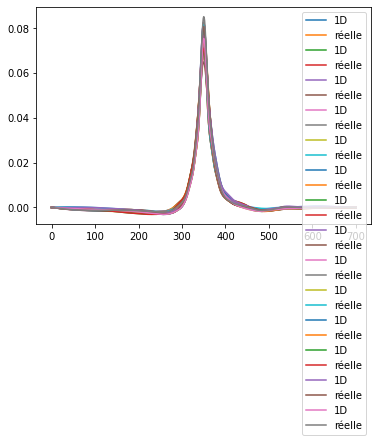

In [5]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
trucks = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]

plt.figure()

for i,truck in enumerate(trucks):
    meters0 = truck.time * truck.speed
    meters0 = np.array(meters0)
    times0 = np.array(truck.time)
    speed = truck.speed
    #plt.plot(np.diag(func2D(meters0,times0)),label=str(speed))
    plt.plot(func1D(truck.speed),label="1D")
    plt.plot(calibration_mt_amp(trucks[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}),label="réelle")
    plt.legend()





**Les résultats sont assez identiques**

## IV/ Interpolation 2D

**Nous ne pouvons pas réaliser l'interpolation 2D que nous souhaitions (LI selon v et t) car les fonctions scipy ne prennent que des grid comme paramètre. Il faut généralement len(x)=len(y)=len(z)**

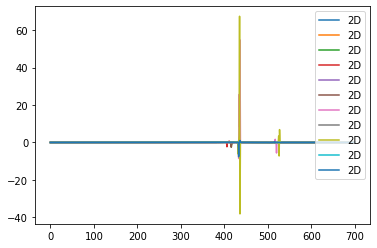

In [6]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
#trucks = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]

plt.figure()

for i,truck in enumerate(trucks) :
    meters0 = truck.time * truck.speed
    meters0 = np.array(meters0[:701])
    times0 = np.array(truck.time[:701])

    plt.plot(np.diag(func2D(meters0,times0)),label="2D")
    #plt.plot(func1D(truck.speed),label="1D")
    #plt.plot(list_infl[i],label="réelle")
    plt.legend()

plt.show()


**L'interpolation 2D ne fonctionne pas**

## V/ Interp1D 

**En ajoutant quelques hautes vitesses des camions de trafic, nous réglons le problème d'affaissement de la LI au dessus de 24m/s.**

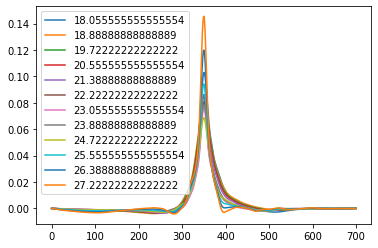

In [7]:
plt.figure()
for i in [x for x in np.arange(65,100,3)]:
    #print(i)
    plt.plot(func1D(i/3.6),label=i/3.6)
    plt.legend()
plt.show()

### V.1 Résultats de l'interpolation 1D - Calibration

Speed :  24.380991984594182
6.696349265547485


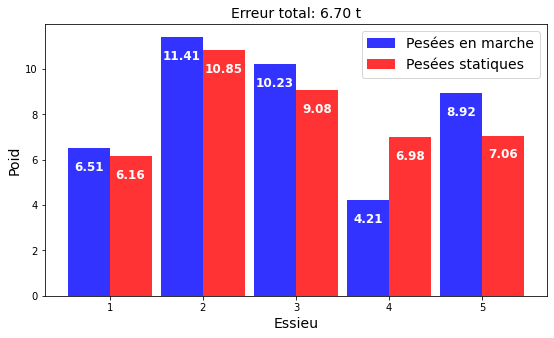

Speed :  23.272699098967962
0.858274505711651


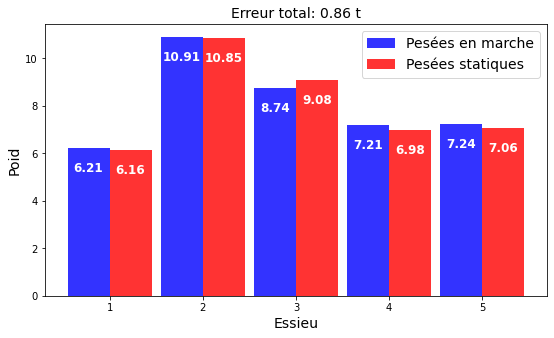

Speed :  23.630769230769232
0.812002854964974


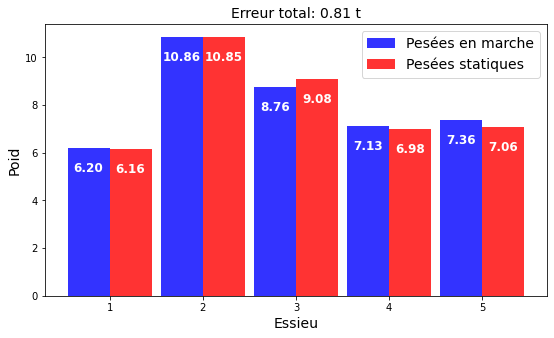

Speed :  24.00002912772182
2.927245153939305


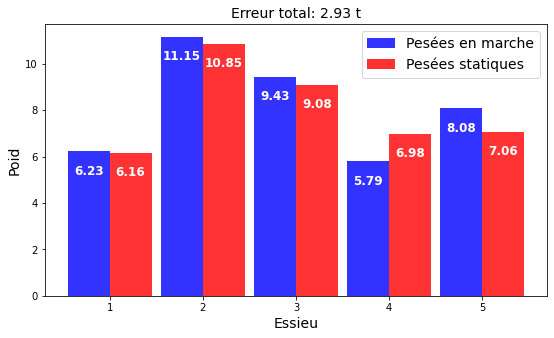

Speed :  21.63376871440886
1.0404644654452895


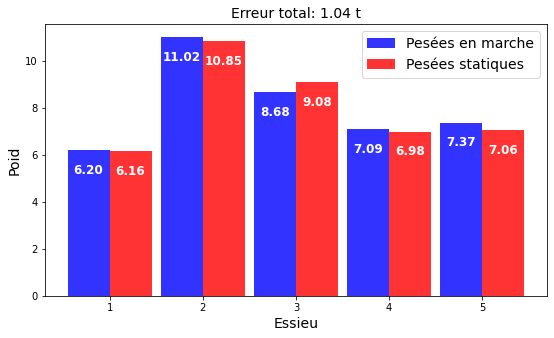

Speed :  23.630778718660313
0.8579083727134869


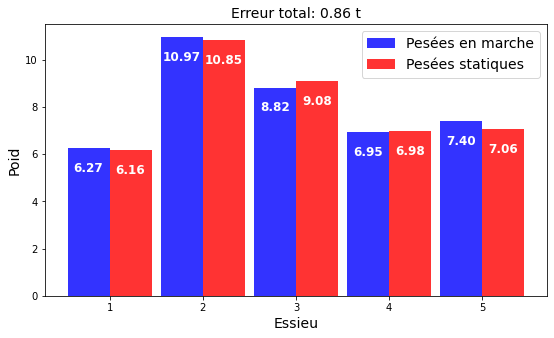

Speed :  18.731689060807692
1.2495376709638508


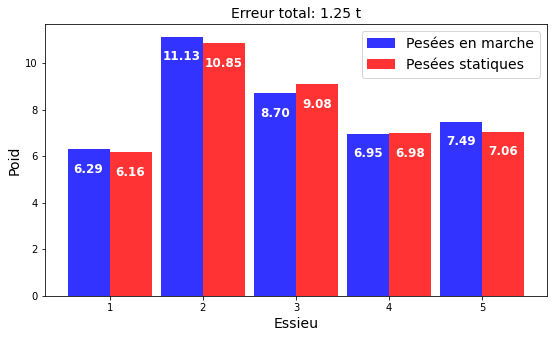

Speed :  18.963018634210332
1.4530085685166396


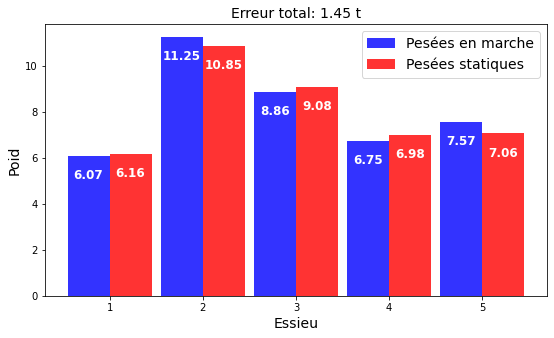

Speed :  18.50599705565925
1.1925859637032046


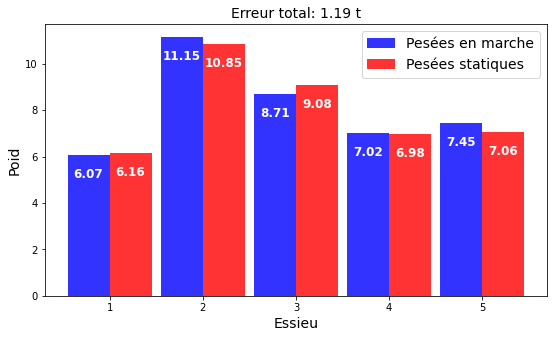

Speed :  21.333341568157582
1.14254126720612


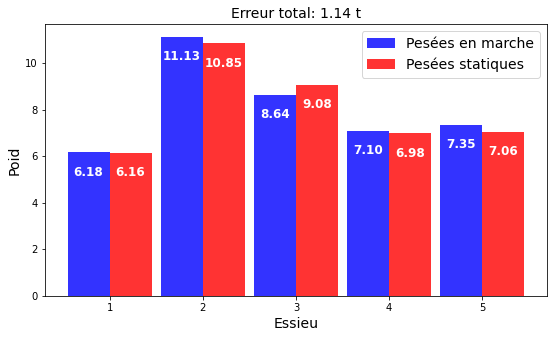

Speed :  18.96294211024312
1.4010561632311918


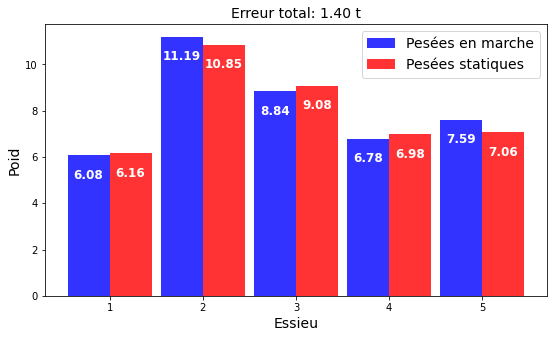

Erreur moyenne  1.7846340229039273


In [8]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]



somme=0
for truck in trucks:
    
    print("Speed : ",truck.speed)
    infl = func1D(truck.speed)
    w = estimation(truck,infl)
    print(np.sum(abs(truck.weights -w)))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
    
print("Erreur moyenne " ,somme/len(trucks))

### V.2 Résultats de l'interpolation 1D - Traffic

Speed :  23.630778718660313
3.407165759967693


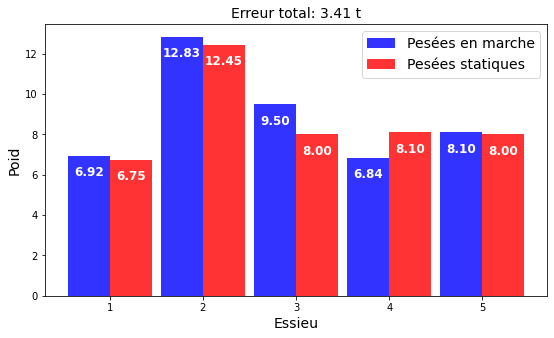

Speed :  23.99998055697778
2.3857597648921427


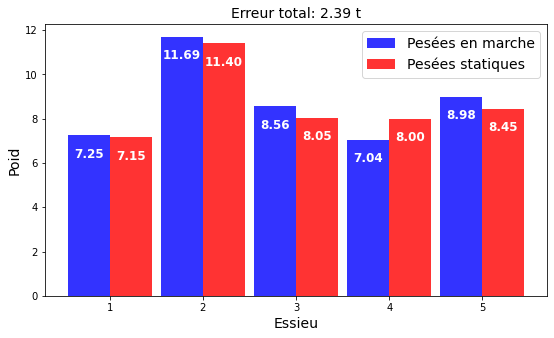

Speed :  23.63081643339881
2.4096939260399957


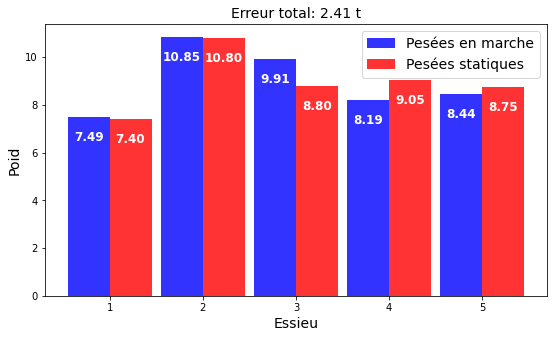

Speed :  25.18025490149026
1.8260163722582803


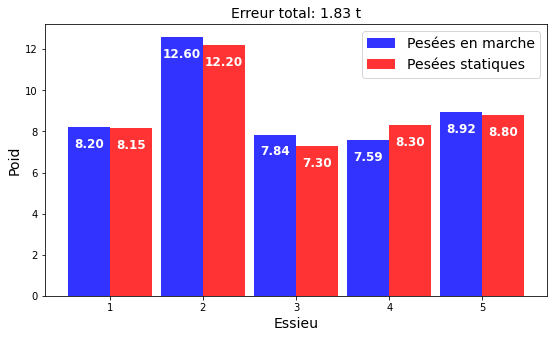

Speed :  22.26084595150235
2.211992793348526


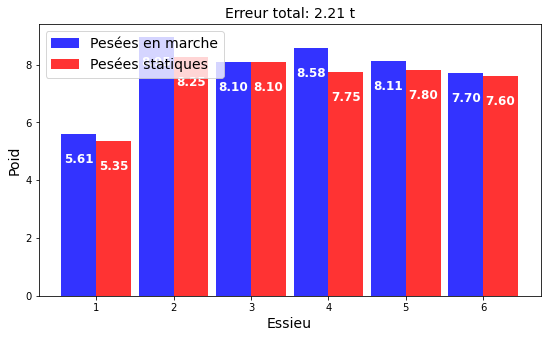

Speed :  22.260903648897617
3.7532177102929785


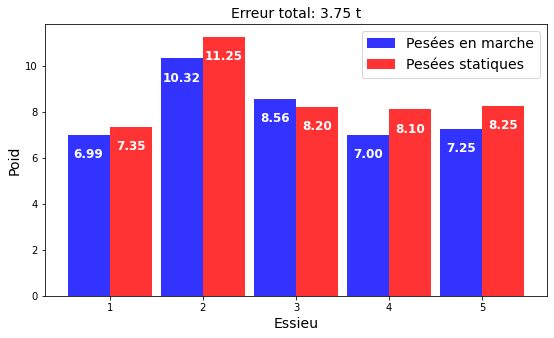

Speed :  24.0
0.9221102585531202


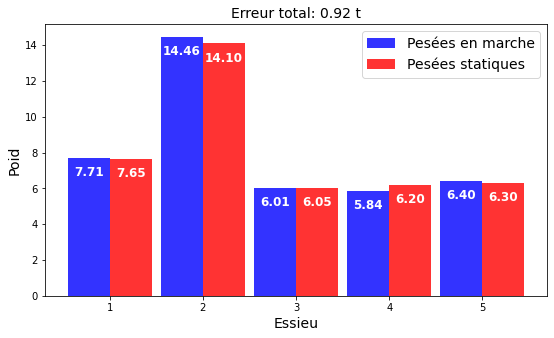

Speed :  24.00002912772182
4.979131148095086


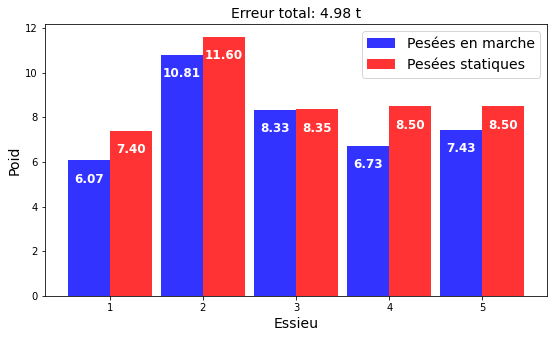

Speed :  24.380962370591252
1.1237000356605789


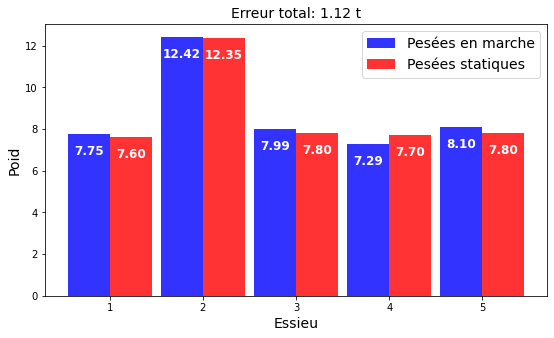

Speed :  23.27274641740299
2.530931042491349


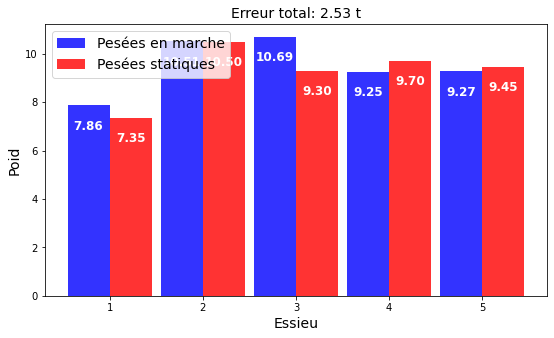

Speed :  24.000047940170667
1.1967510995202009


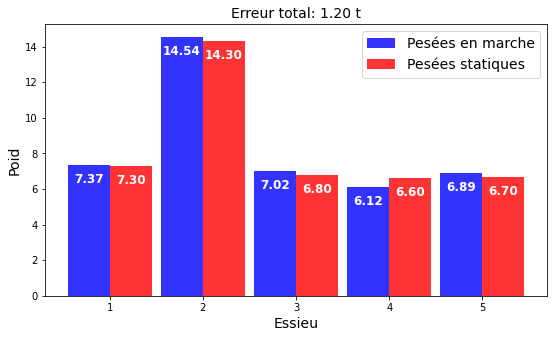

Speed :  24.380892824572964
2.363917478593784


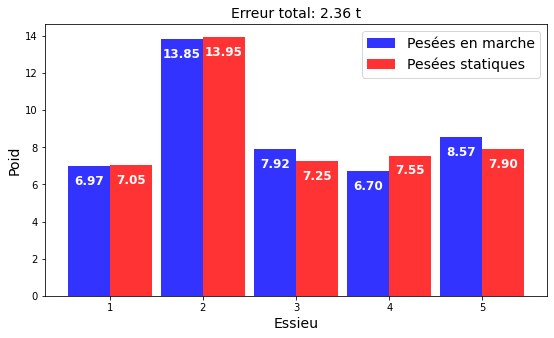

Speed :  23.630750086870428
2.0604049578290304


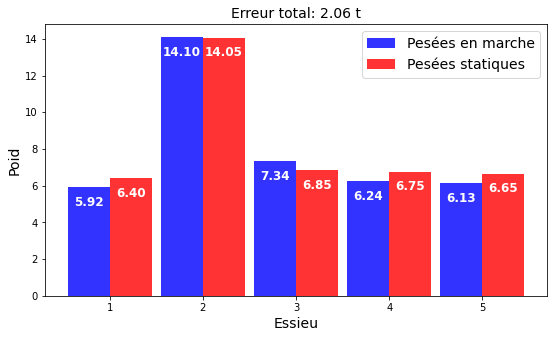

Speed :  23.272717998418727
7.778280065470545


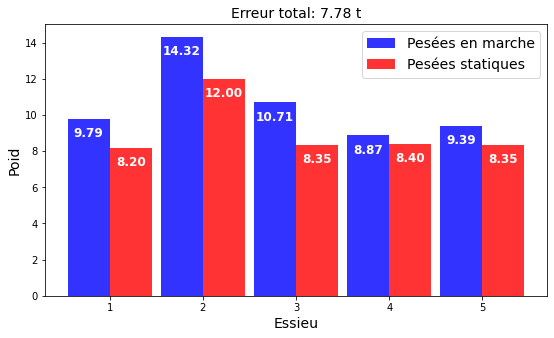

Erreur moyenne  2.782076600929522


In [9]:
somme=0
for truck in trucks_t:
    
    print("Speed : ",truck.speed)
    infl = func1D(truck.speed)
    w = estimation(truck,infl)
    print(np.sum(abs(truck.weights -w)))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks_t))

## VI/ Réimplémentation des fonctions d'interpolation

### VI.1 Interpolation linéaire réimplémentée

**Comme nous l'avons vu, les fonctions d'interpolation scipy ne nous conviennent pas tout à fait. Il peut donc être intéressant de les réimplémenter à la main. Dans un premier temps, nous allons reprendre l'interpolation linéaire. Nous essayerons par la suite d'implémenter une interpolation polynomiale.**

In [10]:
def interp_lin(v_min,v_max,L_min,L_max):
    """
        Données :
            - v_min : vitesse minimale
            - v_max : vitesse maximale
            - L_min : influence à vitesse minimale
            - L_max : influence à vitesse maximale
        Sorties :
            - Retourne la fonction d'interpolation de la LI avec les vitesses
            
    """
    def func_lin(v,t):
        return abs((v-v_max)*L_min+(v-v_min)*L_max)/(v_max-v_min)
    return func_lin

In [11]:
idx = np.argsort(list_speeds)
list_speeds = list_speeds[idx]
list_infl = list_infl[idx]

**Quelques graphes pour comprendre ce qu'il se passe**

[18.50599706 18.73168906 18.96294211 18.96301863 21.33334157 21.63376871
 23.2726991  23.63076923 23.63077872 23.99998056 24.         24.00002913
 24.00002913 24.00004794 24.38089282 24.38096237 24.38099198 25.1802549 ]


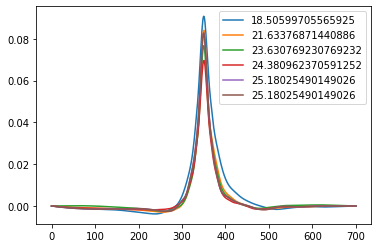

In [12]:
print(list_speeds)
plt.figure()
plt.plot(list_infl[0],label=str(list_speeds[0]))
plt.plot(list_infl[5],label=str(list_speeds[5]))
plt.plot(list_infl[7],label=str(list_speeds[7]))
plt.plot(list_infl[15],label=str(list_speeds[15]))
plt.plot(list_infl[17],label=str(list_speeds[17]))

plt.plot(list_infl[-1],label=str(list_speeds[-1]))
plt.legend()
plt.show()




In [13]:
func_lin = interp_lin(list_speeds[0],list_speeds[3],list_infl[0],list_infl[3])

Speed :  24.380991984594182
39.22005800530697


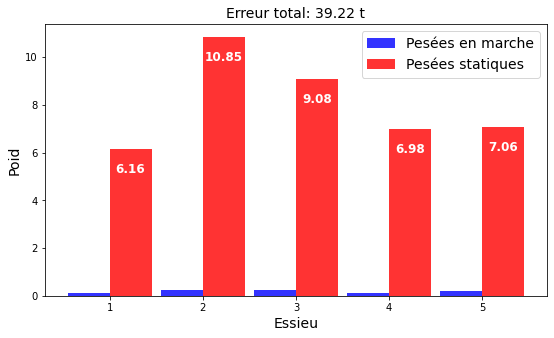

Speed :  23.272699098967962
39.0053571421538


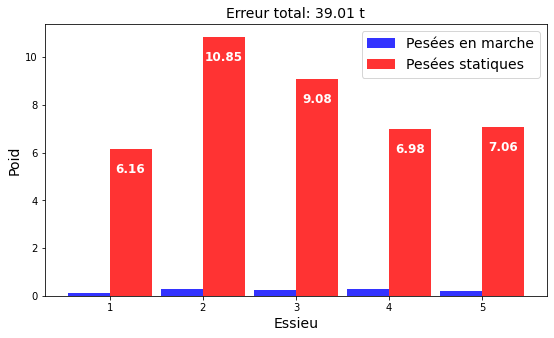

Speed :  23.630769230769232
38.97978208749491


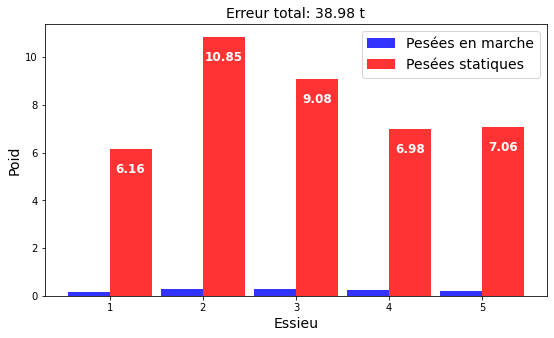

Speed :  24.00002912772182
39.0102021445068


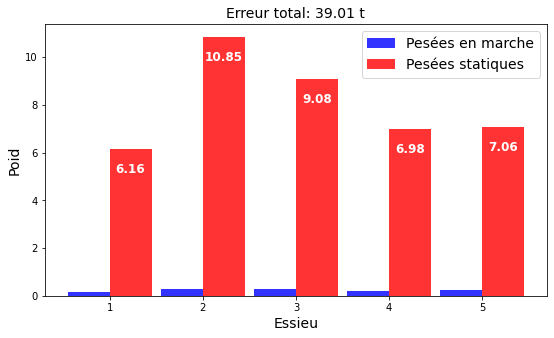

Speed :  21.63376871440886
38.07776421683027


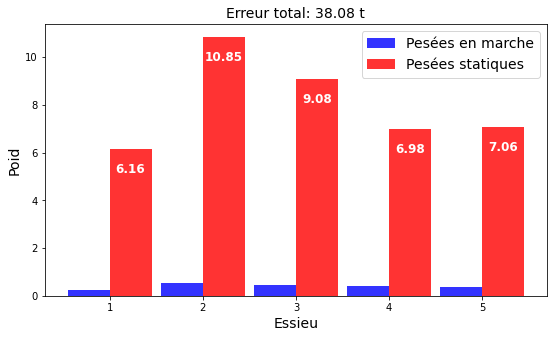

Speed :  23.630778718660313
38.89546157174543


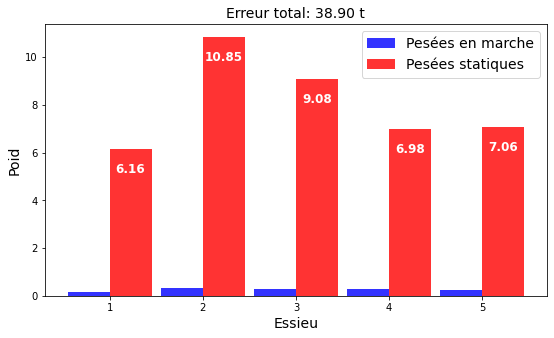

Speed :  18.731689060807692
997.4820175395555


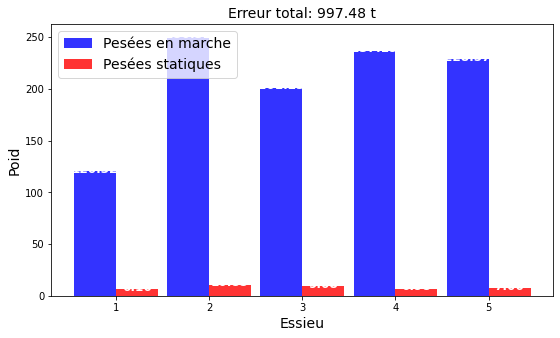

Speed :  18.963018634210332
5.877724094566201


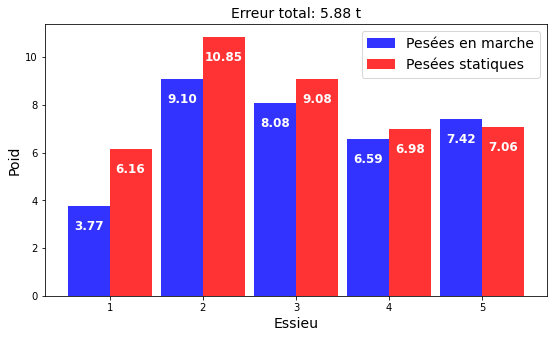

Speed :  18.50599705565925
5.52150863574624


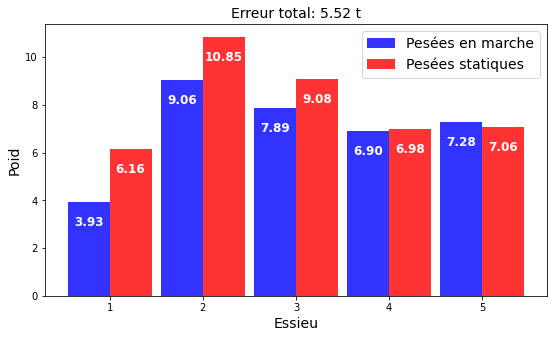

Speed :  21.333341568157582
37.42686743771461


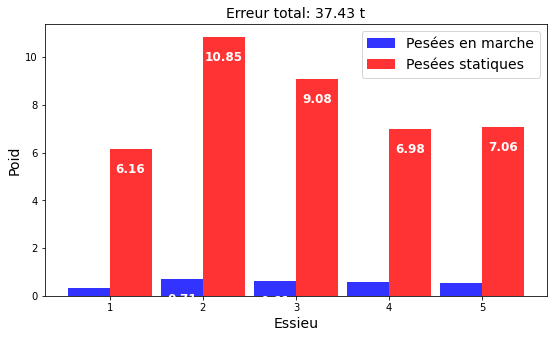

Speed :  18.96294211024312
5.664695986042996


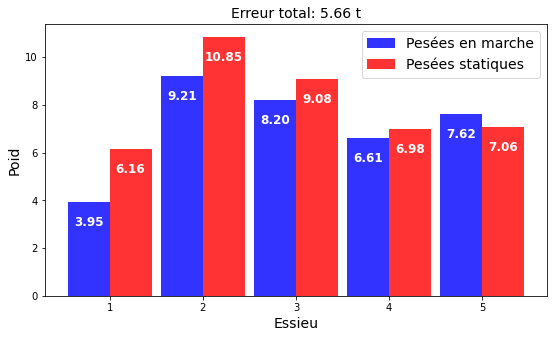

Erreur moyenne  116.83285807833308


In [14]:
somme=0
for truck in trucks:
    
    print("Speed : ",truck.speed)
    infl = func_lin(truck.speed,truck.time)
    w = estimation(truck,infl)
    print(np.sum(abs(truck.weights -w)))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks))

**ça ne donne pas de meilleurs résultats**

### VI.2 Interpolation polynomiale réimplémentée

In [15]:

def interp_poly(list_speeds,list_infl):
    n = list_speeds.shape[0]
    
    def func_poly(v):
        px = 0
        for i in range(0,n):#somme des i = 0 à n
            pi=1
            for j in range(0,n):#produit des j différents de i (x-xj)/(xi-xj)
                if j!=i and list_speeds[i]-list_speeds[j]!=0:
                    pi *= ((v-list_speeds[j])/(list_speeds[i]-list_speeds[j]))
            px = px+ list_infl[i]*pi
            #print("PX : ",px)
            
        return px
    return func_poly


In [16]:
func_poly = interp_poly(list_speeds,list_infl)
"""
plt.figure()
for i in range(15,20):
    print(max(func_poly(i)))
    plt.plot(func_poly(i),label=str(i))
plt.legend()    
plt.show()"""

'\nplt.figure()\nfor i in range(15,20):\n    print(max(func_poly(i)))\n    plt.plot(func_poly(i),label=str(i))\nplt.legend()    \nplt.show()'

### VI.3 Résultats interpolation polynomiale - Calibration

Speed :  24.380991984594182
Max infl = :  0.058099678024116724
6.696349265547485


<Figure size 432x288 with 0 Axes>

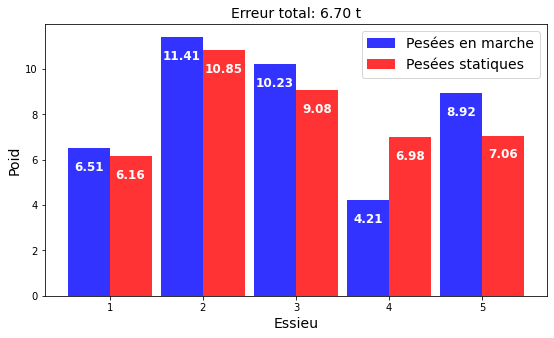

Speed :  23.272699098967962
Max infl = :  0.0753808489460622
0.858274505711651


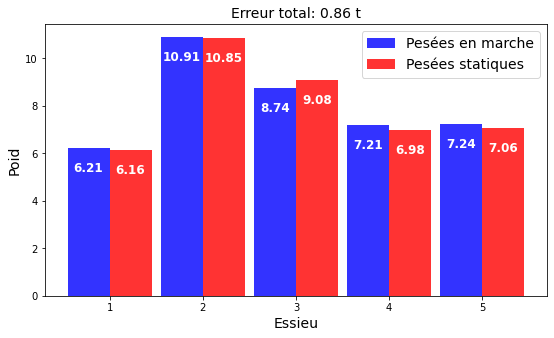

Speed :  23.630769230769232
Max infl = :  0.07664346329201861
0.8120028549649883


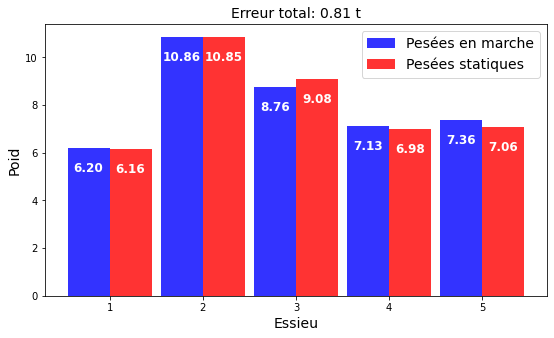

Speed :  24.00002912772182
Max infl = :  0.13358119427768195
18.504435533222853


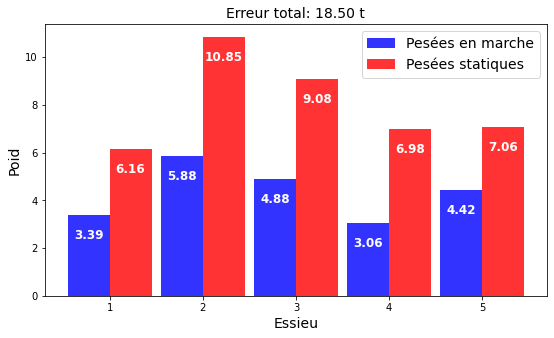

Speed :  21.63376871440886
Max infl = :  0.08402071000870587
1.0404644654452895


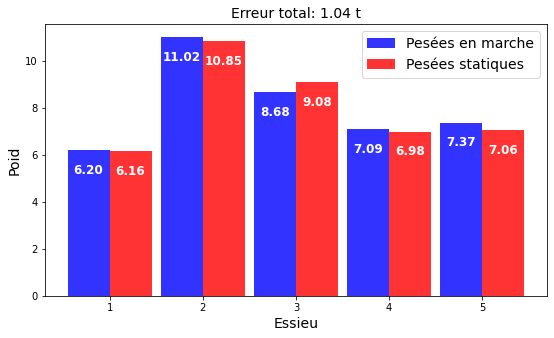

Speed :  23.630778718660313
Max infl = :  0.08249218818299044
0.8579083727134797


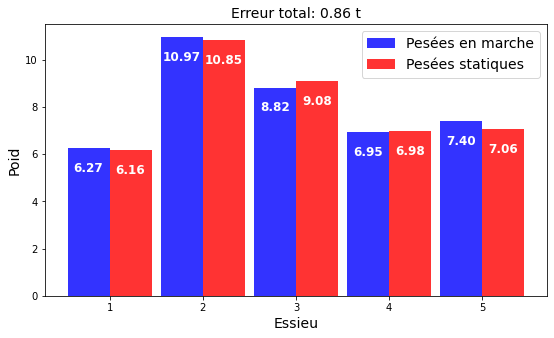

Speed :  18.731689060807692
Max infl = :  0.08466697615975559
1.2495376709638508


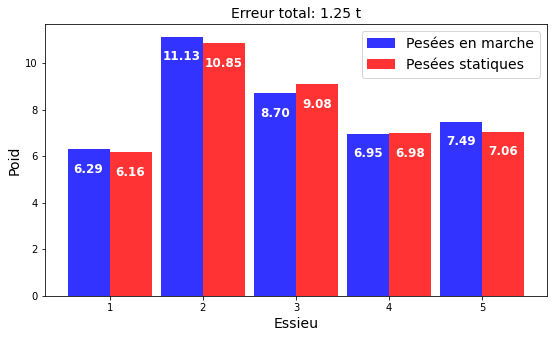

Speed :  18.963018634210332
Max infl = :  0.08334662702676814
1.4530085685166396


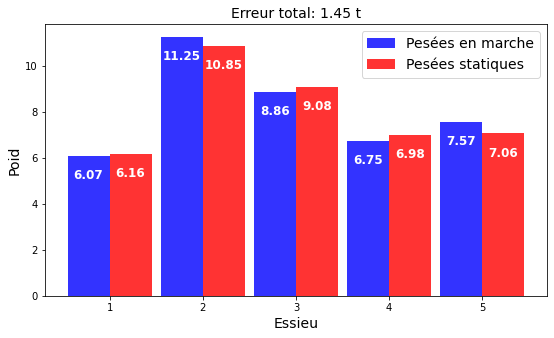

Speed :  18.50599705565925
Max infl = :  0.09074333066227598
1.1925859637032046


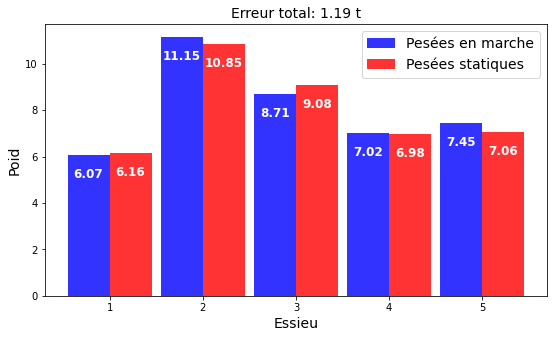

Speed :  21.333341568157582
Max infl = :  0.08674670101360729
1.14254126720612


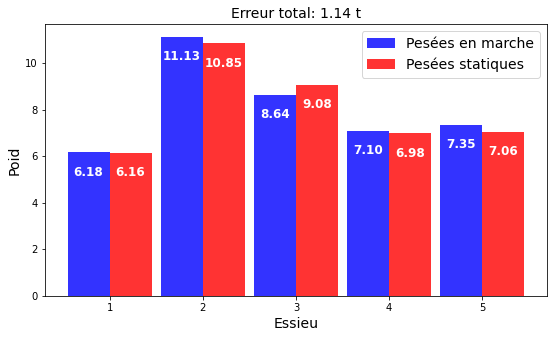

Speed :  18.96294211024312
Max infl = :  0.08627810094983913
1.4010561632311918


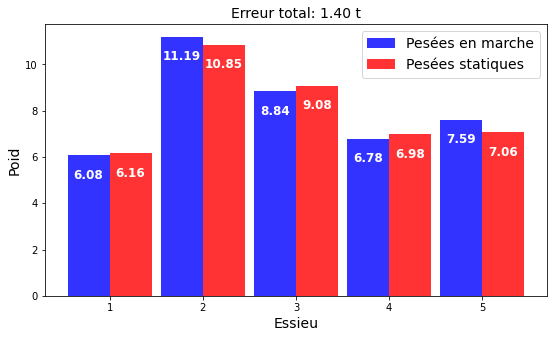

Erreur moyenne  3.200742239202432


In [17]:


#func_poly = interp_poly(list_speeds,list_infl)
#print(func_poly(truck.speed,truck.time).shape)
#print(func_poly(truck.speed,truck.time))

somme=0
plt.figure()
for truck in trucks:
    print("Speed : ",truck.speed)
    infl = func_poly(truck.speed)
    print("Max infl = : ",max(infl))
    w = estimation(truck,infl)
    print(np.sum(abs(truck.weights -w)))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks))

### VI.4 Résultats interpolation polynomiale - Traffic

Speed :  23.630778718660313
0.08249218818299044
3.4071657599676897


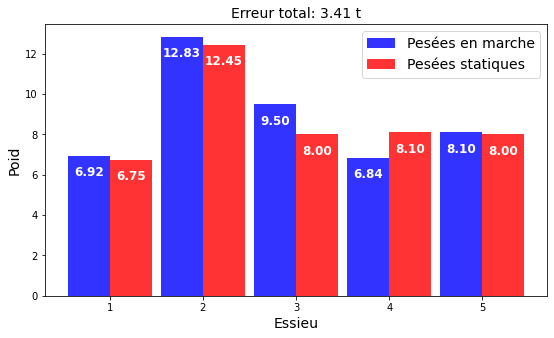

Speed :  23.99998055697778
0.07625968300864376
2.3857597648921427


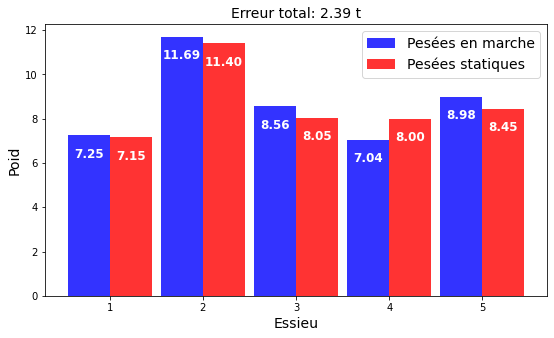

Speed :  23.63081643339881
4045406.3964084727
44.79999951803925


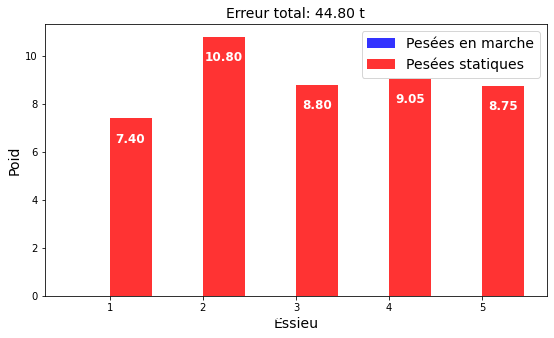

Speed :  25.18025490149026
0.08269939317796766
1.8260163722582803


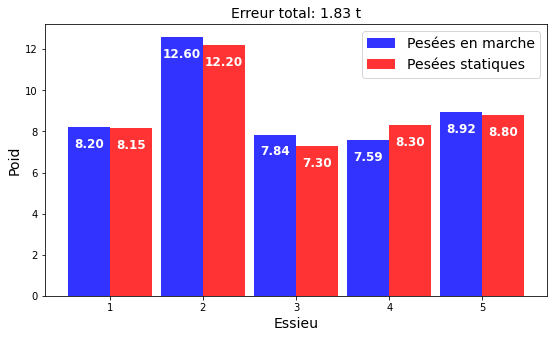

Speed :  22.26084595150235
5.403431375337634e+18
44.85


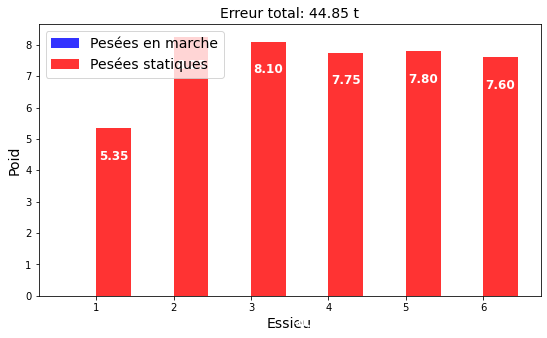

Speed :  22.260903648897617
5.402596797951323e+18
43.15


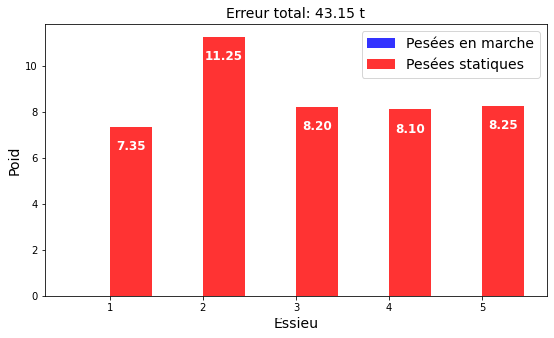

Speed :  24.0
0.07401463908832162
0.9221102585531211


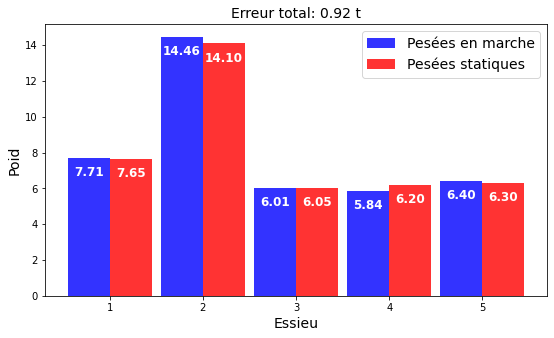

Speed :  24.00002912772182
0.13358119427768195
23.370510026798247


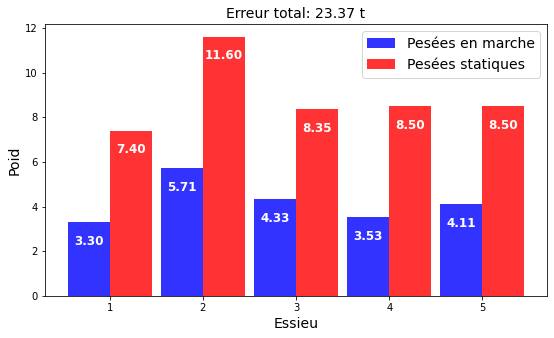

Speed :  24.380962370591252
0.06956538311255228
1.1237000356605789


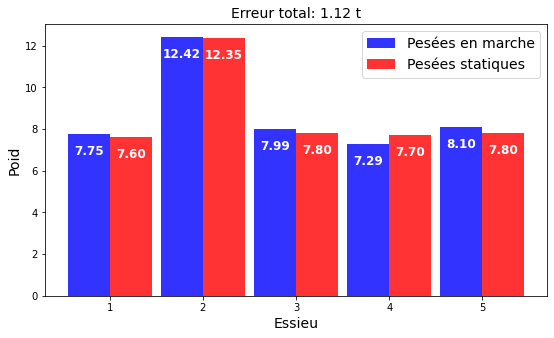

Speed :  23.27274641740299
1170748884217.684
46.299999999998505


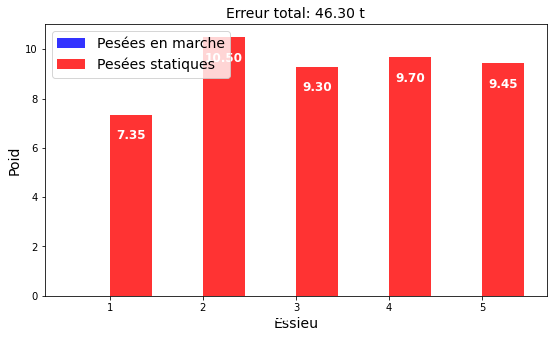

Speed :  24.000047940170667
0.07421829911704961
1.1967510995202009


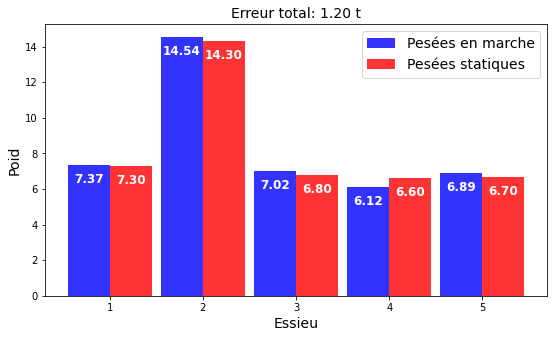

Speed :  24.380892824572964
0.07102102744199651
2.363917478593784


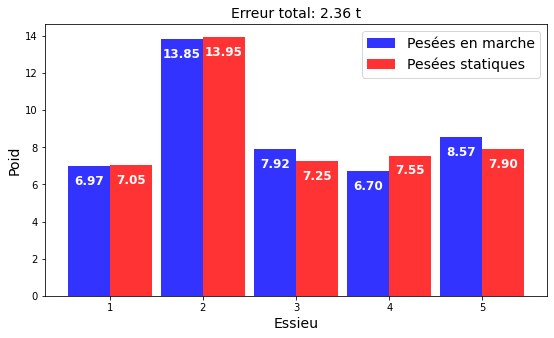

Speed :  23.630750086870428
1246460.077524973
40.69999895682485


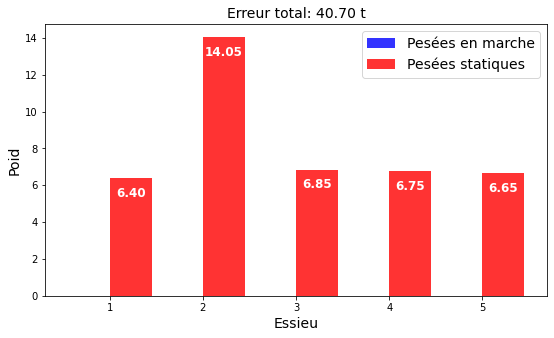

Speed :  23.272717998418727
467772117825.8215
45.29999999999609


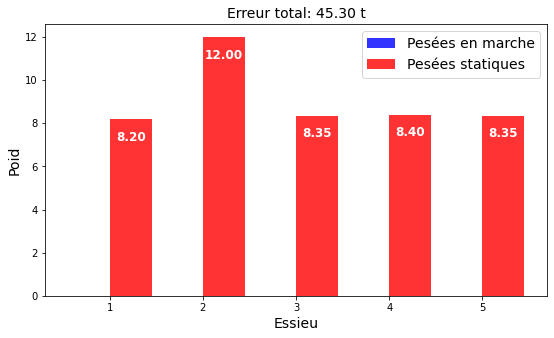

Erreur moyenne  21.549709233650198


In [18]:
somme=0
for truck in trucks_t:
    
    print("Speed : ",truck.speed)
    infl = func_poly(truck.speed)
    print(max(infl))
    w = estimation(truck,infl)
    print(np.sum(abs(truck.weights -w)))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks_t))

## VII/ Amplitude des LI / Vitesses

**Comme le principe de l'interpolation sur les LI semble ne pas fonctionner au dessus de 24m/s (ou moins bien), nous allons afficher les maximums des LI en fonction des vitesses pour se donner une idée de ce qu'il se passe.**

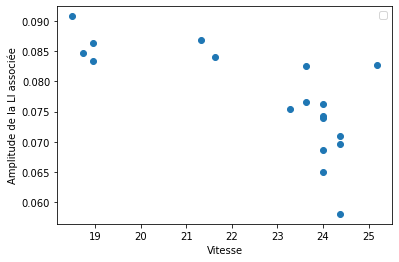

In [19]:
list_max_infl = [max(infl) for infl in list_infl]

plt.figure()
plt.plot(list_speeds,list_max_infl,'o')
plt.xlabel("Vitesse")
plt.ylabel("Amplitude de la LI associée")
plt.legend()
plt.show()

## VIII/ Par Machine Learning ?

In [20]:
print(type(list_speeds))
x = np.expand_dims(list_speeds,axis=1)
y = list_infl
from sklearn import linear_model
reg = linear_model.RidgeCV()
reg.fit(x,y)

<class 'numpy.ndarray'>


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [21]:
def preprocess(speed):
    return np.array([[speed]])
reg.predict(preprocess(24)).shape

(1, 701)

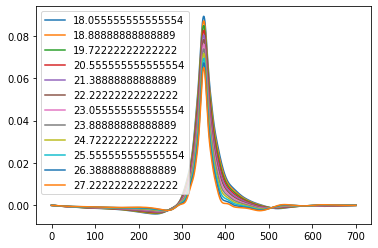

In [22]:
plt.figure()
for i in [x for x in np.arange(65,100,3)]:
    #print(i)
    plt.plot(reg.predict(preprocess(i/3.6))[0],label=i/3.6)
    plt.legend()
plt.show()

Speed :  23.630778718660313
0.07451680225498675
5.110221836951657


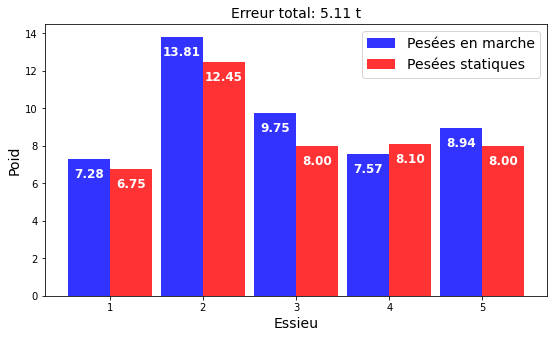

Speed :  23.99998055697778
0.07354230986998068
5.574652111928866


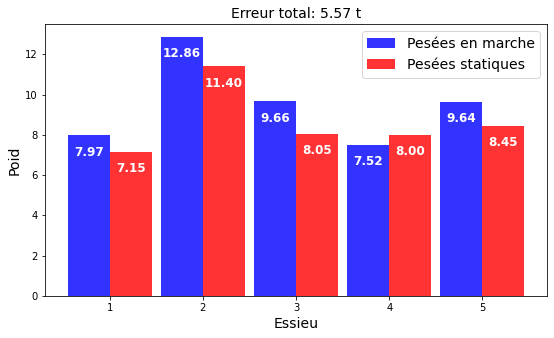

Speed :  23.63081643339881
0.07451670270855536
3.3057313308022795


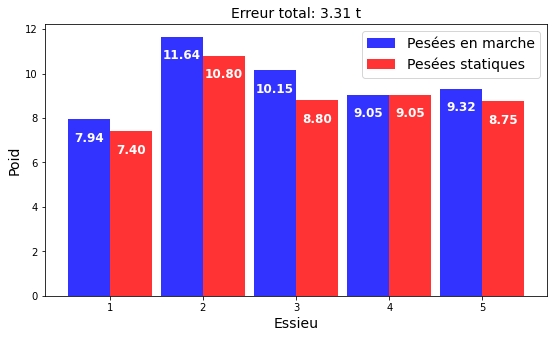

Speed :  25.18025490149026
0.0704270264624359
8.588936936229839


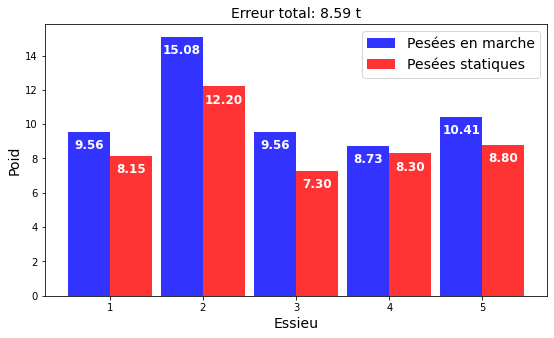

Speed :  22.26084595150235
0.07813268091813089
2.313976674051897


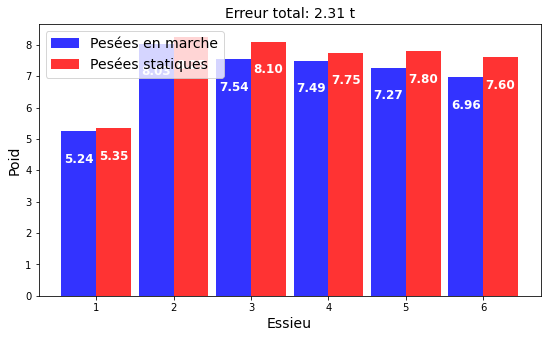

Speed :  22.260903648897617
0.07813252862833575
6.454585389752342


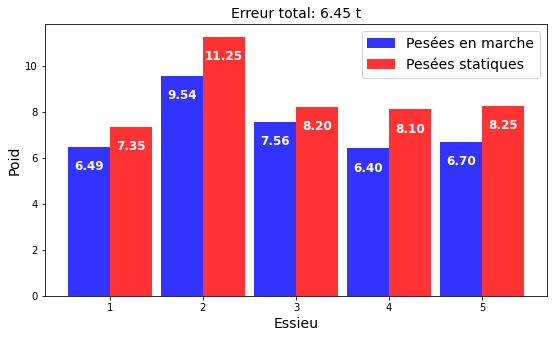

Speed :  24.0
0.07354225855095914
3.671091365129544


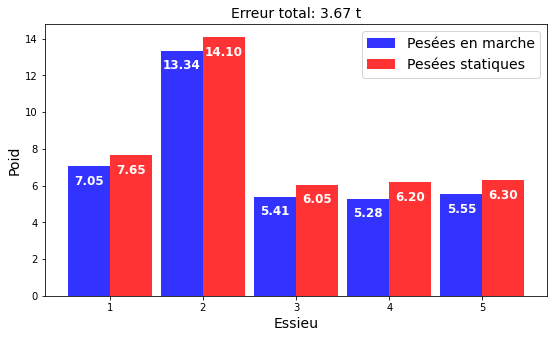

Speed :  24.00002912772182
0.07354218166958922
3.458574386085586


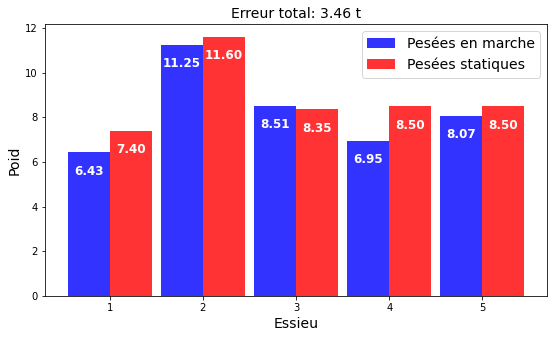

Speed :  24.380962370591252
0.07253672474645026
1.4511685411483715


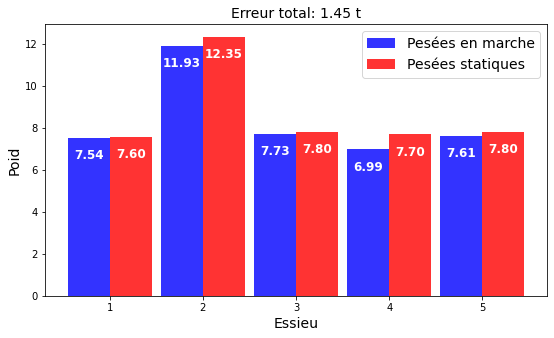

Speed :  23.27274641740299
0.07546181312695714
3.8838780022375605


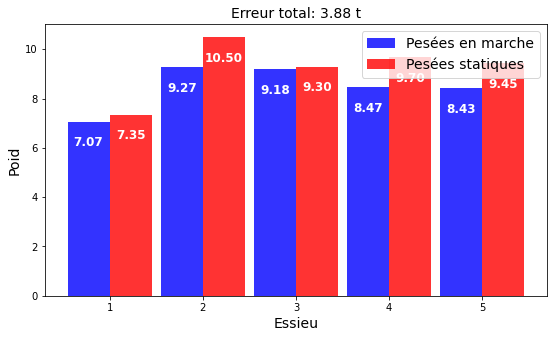

Speed :  24.000047940170667
0.07354213201493899
1.4214365202646793


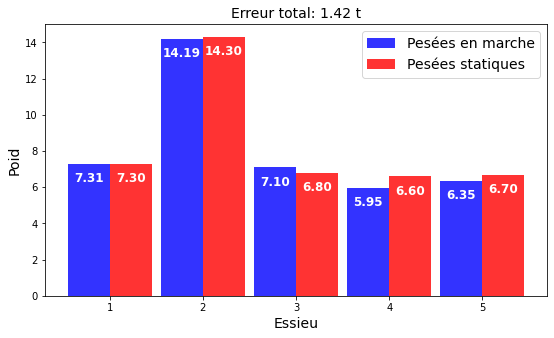

Speed :  24.380892824572964
0.07253690831017665
2.8836224682917706


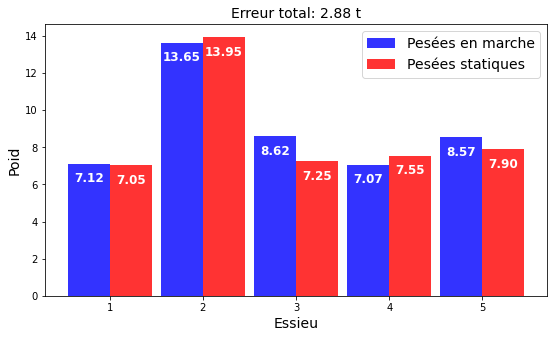

Speed :  23.630750086870428
0.07451687782736563
1.4953988063074375


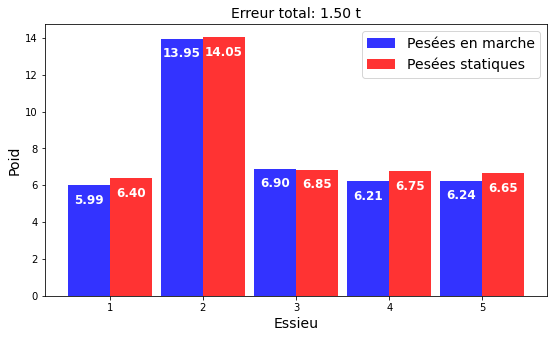

Speed :  23.272717998418727
0.07546188813764473
2.606515222402713


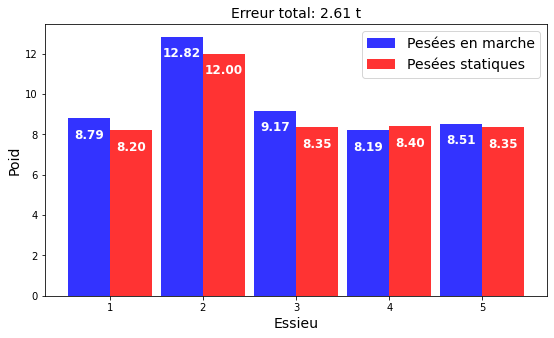

Erreur moyenne  3.7299849708274664


In [23]:
somme=0
for truck in trucks_t:
    
    print("Speed : ",truck.speed)
    infl = reg.predict(preprocess(truck.speed))[0]
    print(max(infl))
    w = estimation(truck,infl)
    print(np.sum(abs(truck.weights -w)))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks_t))

In [24]:
calibration_trucks[0].time[0] - calibration_trucks[0].time[1]

-0.00195312